<a href="https://colab.research.google.com/github/chasubeen/Store-Sales-Forecasting/blob/%EC%88%98%EB%B9%88/3_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 패키지 로딩**

In [1]:
### 기본
import numpy as np
import pandas as pd
import os
import gc
import warnings

### 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # 동적 시각화

## 옵션 설정
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

### 시계열 분석 패키지(ACF, PACF)
import statsmodels.api as sm

# **1. 데이터 불러오기**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA 8기/OB/winter_proj/data/train_preprocessed.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA 8기/OB/winter_proj/data/test_preprocessed.csv')

In [4]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,Quito,Pichincha,D,13,93.14,0.00,National
1,1,2013-01-01,41,SEAFOOD,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
2,2,2013-01-01,41,SCHOOL AND OFFICE SUPPLIES,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
3,3,2013-01-01,41,PRODUCE,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National
4,4,2013-01-01,41,PREPARED FOODS,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705087 entries, 0 to 2705086
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   float64
 6   city          object 
 7   state         object 
 8   type          object 
 9   cluster       int64  
 10  dcoilwtico    float64
 11  transactions  float64
 12  holiday       object 
dtypes: float64(4), int64(3), object(6)
memory usage: 268.3+ MB


In [6]:
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,holiday
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.80,Weekday
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.80,Weekday
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.80,Weekday
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.80,Weekday
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.80,Weekday


In [7]:
# date를 datetime 형으로 변경

train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705087 entries, 0 to 2705086
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   float64       
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  transactions  float64       
 12  holiday       object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memory usage: 268.3+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
 5   city         28512 non-null  object        
 6   state        28512 non-null  object        
 7   type         28512 non-null  object        
 8   cluster      28512 non-null  int64         
 9   dcoilwtico   28512 non-null  float64       
 10  holiday      28512 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 2.4+ MB


- 제대로 변경되었다.

## **📌 Data Description**
| Index | Column        | Description                     |
|-------|---------------|---------------------------------|
| 1     | id            | 각 데이터를 구분하기 위한 식별자|
| 2     | date          |판매일자                         |
| 3     | store_nbr     |매장 고유 식별번호               |
| 4     | family        |판매되는 제품군 유형             |
| 5     | sales         |매출액, **target 변수**        |
| 6     | onpromotion   |프로모션 대상 제품 수            |
| 7     | city          |도시                             |
| 8     | state         |주                               |
| 9     | type          |매장 유형                        |
| 10    | cluster       |유사한 매장들의 군집             |
| 11    | dcoilwtico    |유가(기름값)                     |
| 12    | transactions  |거래량                           |
| 13    | holiday       |공휴일 종류                      |



# **2. 시계열 분석**
- target 변수에 대한 시계열 분석을 진행해 보자.

In [10]:
### 시계열 분석 시에는 일별 평균값을 활용할 예정

# sales가 없는(0인) 데이터는 제외
train2 = train[train['sales'] != 0]

# 일별 평균 계산
daily_average = train2.groupby(['date'])['sales'].mean()

## **2-1. 시도표**

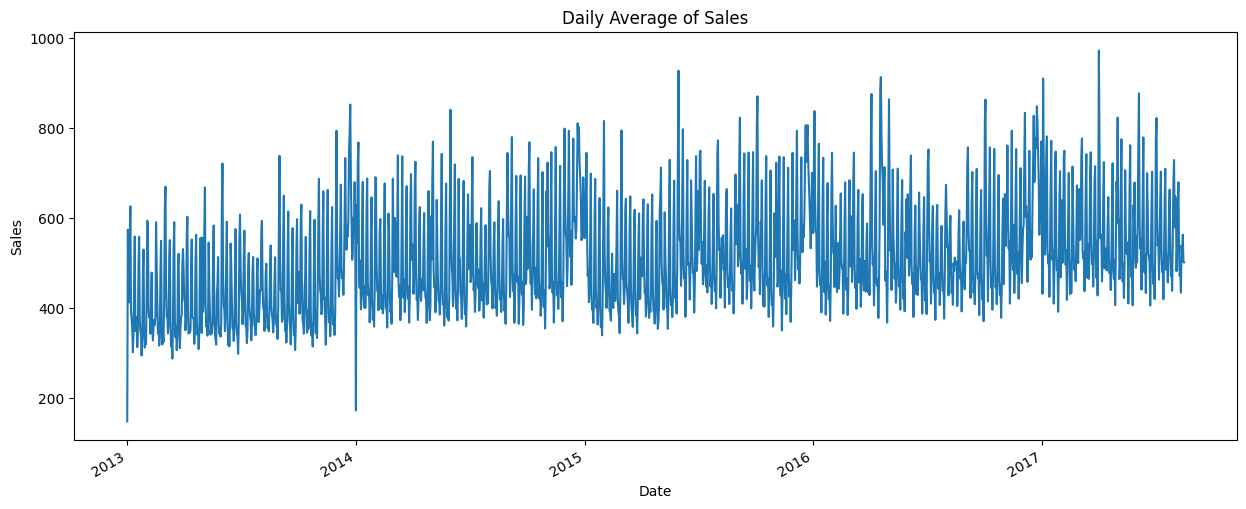

In [11]:
daily_average.plot(figsize = (15, 6))
plt.title('Daily Average of Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

- 중간중간 휴업으로 인한 불규칙성을 보임
- 특히 2013, 2014년 초에 급격한 매출 저하를 보이는 구간들이 존재

## **2-2. 시계열 분해(time series decomposition)**

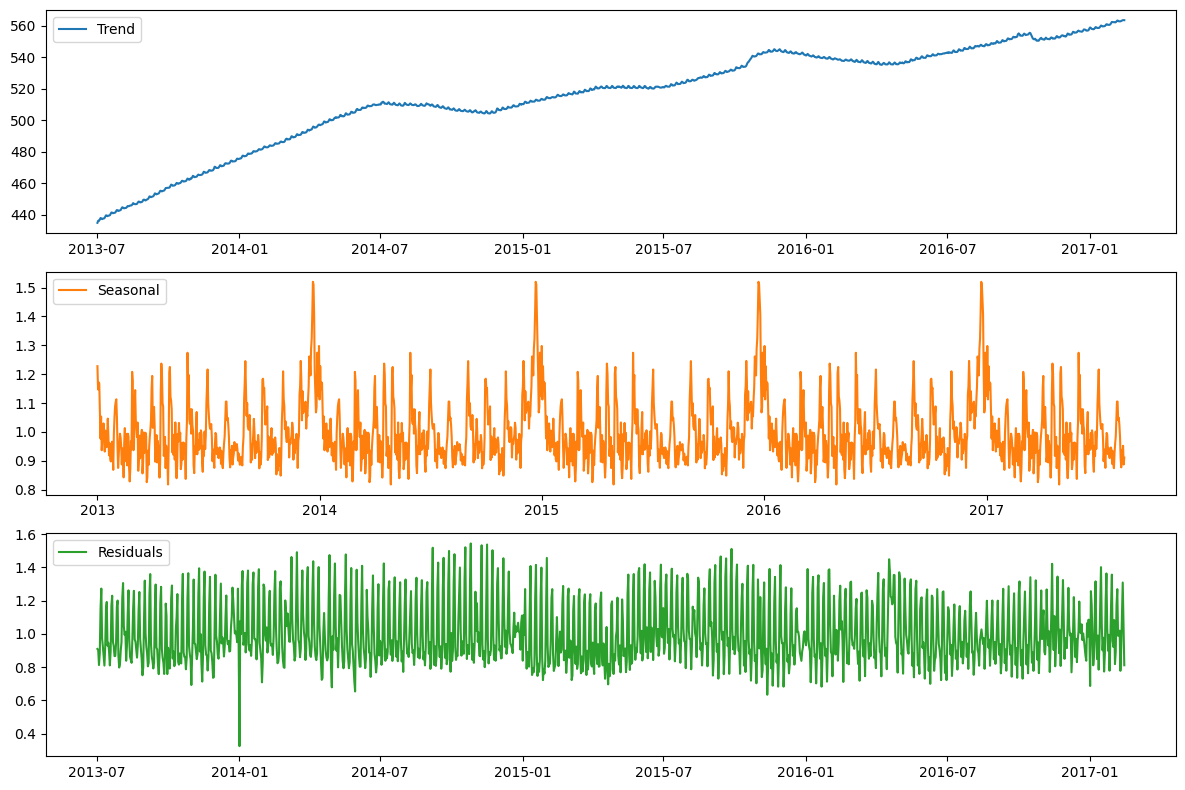

In [12]:
## 시계열 데이터 분해(연 단위로 분해)
result = sm.tsa.seasonal_decompose(daily_average, model='multiplicative', period=365)

# 색상 설정
colors = plt.cm.tab10.colors

# 시각화
plt.figure(figsize=(12, 8))

# 추세(Trend)
plt.subplot(3, 1, 1)
plt.plot(result.trend, label='Trend', color=colors[0])
plt.legend(loc='upper left')

# 계절성(Seasonality)
plt.subplot(3, 1, 2)
plt.plot(result.seasonal, label='Seasonal', color=colors[1])
plt.legend(loc='upper left')

# 잔차(Residuals) 분석
plt.subplot(3, 1, 3)
plt.plot(result.resid, label='Residuals', color=colors[2])
plt.legend(loc='upper left')

# 레이아웃 조정
plt.tight_layout()

# 시각화 표시
plt.show()

- 추세(Trend)
  - 우상향 추세를 보인다.
  > 향후에도 매출액이 증가할 것이라고 예측할 수 있다.

- 계절성(Seasonality)
  - 주로 연말(11~12월)에 매출이 증가하고 이후 감소한다.
  > 계절적 주기성이 존재한다.
  
- 잔차 분석
  - 잔차에 어떠한 패턴을 보이고 있지 않다.


## **2-3. 정상성(Stationarity)**

### **1️⃣ ACF, PACF**

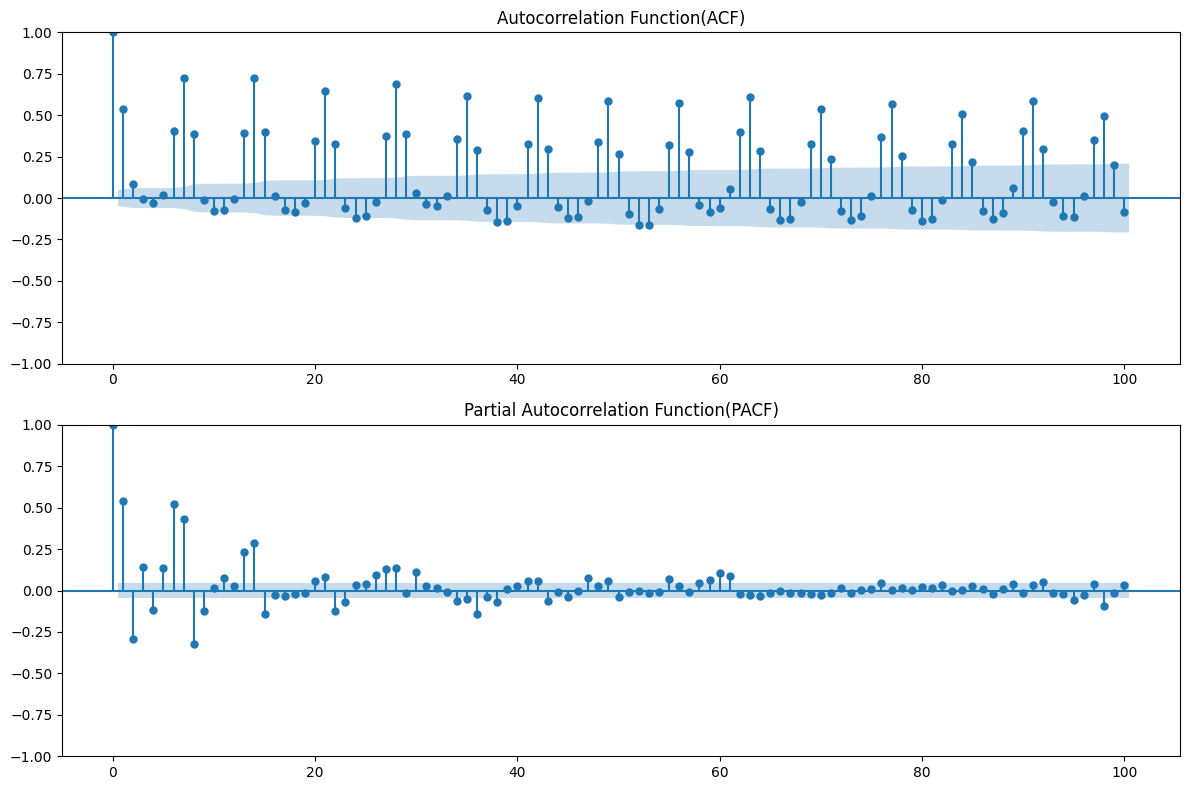

In [13]:
# ACF 및 PACF 계산 및 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF 시각화
sm.graphics.tsa.plot_acf(daily_average, lags=100, ax=axes[0])
axes[0].set_title('Autocorrelation Function(ACF)')

# PACF 시각화
sm.graphics.tsa.plot_pacf(daily_average, lags=100, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function(PACF)')

# 레이아웃 조정
plt.tight_layout()

# 시각화 표시
plt.show()

- ACF 그래프 시각화 결과 특정 패턴이 존재한다
  - 곡선의 형태를 가지며 점점 감소하는 형태

> 비정상 시계열이라고 짐작할 수 있다.

- PACF 그래프를 통해서는 별다른 특징을 파악하긴 어렵다.



### **2️⃣ ADF 검정(Augmented Dickey-Fuller Test)**
- 시계열 데이터의 안정성을 평가하는 통계적인 방법
  - 다음 가설을 검증하며, 귀무가설이 기각되면 해당 시계열은 안정적이라고 간주
    - 귀무가설(H0): 시계열 데이터는 단위근(Non-stationary)을 가진다.  
      (즉, 안정적이지 않다)
    - 대립가설(H1): 시계열 데이터는 안정적이다.

In [14]:
from statsmodels.tsa.stattools import adfuller

# ADF 검정 수행
result = adfuller(daily_average)

# 결과 출력
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -4.077050002235016
p-value: 0.001056669423237086


시계열 데이터는 안정적이다.

> 상충된 결과가 도출됨
> 시각적으로 너무나도 비정상 시계열의 특징을 띄고 있다.

**❓ 비정상성은 어떻게 해결하나?**
- 시계열 분석에서 정상성은 중요한 가정 중 하나
  - 통계적 추정의 안정성, 예측 성능 향상
- 주로 차분 등을 활용하여 정상성을 확보하고자 함

---
현재 우리는 2가지 문제점이 존재

1) 매장마다 개업 일자가 다름  
2) 중간에 휴업을 한 경우들도 존재  

> 차분의 어려움  
> 다른 파생 변수들을 통해 보완할 예정  


### **3️⃣ 시간 관련 변수**
- 시간적인 정보를 제공하기 위한 파생 변수들을 생성하자.

In [15]:
train['year'] = train['date'].dt.year # 연도
train['quarter'] = train['date'].dt.quarter # 분기별
train['month'] = train['date'].dt.month # 월
train['day_of_week'] = train['date'].dt.dayofweek # 요일

In [16]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,holiday,year,quarter,month,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,Quito,Pichincha,D,13,93.14,0.00,National,2013,1,1,1
1,1,2013-01-01,41,SEAFOOD,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National,2013,1,1,1
2,2,2013-01-01,41,SCHOOL AND OFFICE SUPPLIES,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National,2013,1,1,1
3,3,2013-01-01,41,PRODUCE,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National,2013,1,1,1
4,4,2013-01-01,41,PREPARED FOODS,0.00,0.00,Machala,El Oro,D,4,93.14,0.00,National,2013,1,1,1


In [17]:
test['year'] = test['date'].dt.year # 연도
test['quarter'] = test['date'].dt.quarter # 분기별
test['month'] = test['date'].dt.month # 월
test['day_of_week'] = test['date'].dt.dayofweek # 요일

In [18]:
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,holiday,year,quarter,month,day_of_week
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.80,Weekday,2017,3,8,2
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.80,Weekday,2017,3,8,2
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.80,Weekday,2017,3,8,2
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.80,Weekday,2017,3,8,2
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.80,Weekday,2017,3,8,2


# **3. EDA**

## **3-1. type**
- type에 따라 store은 어떻게 구분될 것일까?

In [19]:
### type에 따른 매장 수

for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'store_nbr'].nunique()))

type A: 9
type B: 8
type C: 15
type D: 18
type E: 4


In [20]:
### type 별 제품군

for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'family'].nunique()))

type A: 32
type B: 32
type C: 32
type D: 33
type E: 32


In [21]:
### 타입별 주

for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'state'].unique()))

type A: ['Pichincha' 'Guayas' 'Tungurahua' 'Manabi']
type B: ['Guayas' 'Azuay' 'Pichincha' 'Los Rios' 'Santo Domingo de los Tsachilas']
type C: ['El Oro' 'Guayas' 'Manabi' 'Los Rios' 'Pichincha' 'Bolivar'
 'Santo Domingo de los Tsachilas' 'Imbabura' 'Cotopaxi' 'Chimborazo'
 'Pastaza']
type D: ['Pichincha' 'El Oro' 'Azuay' 'Loja' 'Santo Domingo de los Tsachilas'
 'Tungurahua' 'Guayas' 'Santa Elena' 'Manabi']
type E: ['Esmeraldas' 'Guayas']


In [22]:
### 타입별 도시

for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'city'].unique()))

type A: ['Quito' 'Guayaquil' 'Ambato' 'Manta']
type B: ['Guayaquil' 'Cuenca' 'Quito' 'Cayambe' 'Babahoyo' 'Santo Domingo']
type C: ['Machala' 'Playas' 'El Carmen' 'Quevedo' 'Quito' 'Guaranda'
 'Santo Domingo' 'Ibarra' 'Latacunga' 'Riobamba' 'Guayaquil' 'Puyo']
type D: ['Quito' 'Machala' 'Cuenca' 'Loja' 'Santo Domingo' 'Ambato' 'Guayaquil'
 'Daule' 'Salinas' 'Manta']
type E: ['Esmeraldas' 'Guayaquil' 'Libertad']


In [23]:
### 타입별 cluster

for i in ["A", 'B', 'C', 'D', 'E']:
  print("type {}: {}".format(i, train.loc[(train['type'] == i),'cluster'].unique()))

type A: [11  5 14 17]
type B: [ 6 16 10]
type C: [ 3 12 15  7]
type D: [13  4  9  2  8  1 10]
type E: [10]


## **3-2. cluster**

In [24]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'store_nbr'].nunique()))

cluster 1: 3
cluster 2: 2
cluster 3: 7
cluster 4: 3
cluster 5: 1
cluster 6: 6
cluster 7: 2
cluster 8: 3
cluster 9: 2
cluster 10: 6
cluster 11: 3
cluster 12: 1
cluster 13: 4
cluster 14: 4
cluster 15: 5
cluster 16: 1
cluster 17: 1


In [25]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'family'].nunique()))

cluster 1: 33
cluster 2: 33
cluster 3: 32
cluster 4: 33
cluster 5: 32
cluster 6: 32
cluster 7: 32
cluster 8: 33
cluster 9: 33
cluster 10: 33
cluster 11: 32
cluster 12: 32
cluster 13: 33
cluster 14: 32
cluster 15: 32
cluster 16: 32
cluster 17: 32


In [26]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'state'].unique()))

cluster 1: ['Guayas' 'Santa Elena']
cluster 2: ['Azuay']
cluster 3: ['El Oro' 'Guayas' 'Manabi' 'Los Rios' 'Santo Domingo de los Tsachilas']
cluster 4: ['El Oro' 'Loja' 'Santo Domingo de los Tsachilas']
cluster 5: ['Pichincha']
cluster 6: ['Guayas' 'Azuay' 'Pichincha' 'Santo Domingo de los Tsachilas']
cluster 7: ['Chimborazo' 'Pastaza']
cluster 8: ['Pichincha']
cluster 9: ['Pichincha' 'Tungurahua']
cluster 10: ['Esmeraldas' 'Guayas' 'Los Rios']
cluster 11: ['Pichincha' 'Manabi']
cluster 12: ['Pichincha']
cluster 13: ['Pichincha' 'Manabi']
cluster 14: ['Pichincha' 'Tungurahua']
cluster 15: ['Bolivar' 'Imbabura' 'Pichincha' 'Cotopaxi']
cluster 16: ['Pichincha']
cluster 17: ['Guayas']


In [27]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'city'].unique()))

cluster 1: ['Guayaquil' 'Daule' 'Salinas']
cluster 2: ['Cuenca']
cluster 3: ['Machala' 'Playas' 'El Carmen' 'Quevedo' 'Santo Domingo' 'Guayaquil']
cluster 4: ['Machala' 'Loja' 'Santo Domingo']
cluster 5: ['Quito']
cluster 6: ['Guayaquil' 'Cuenca' 'Quito' 'Cayambe' 'Santo Domingo']
cluster 7: ['Riobamba' 'Puyo']
cluster 8: ['Quito']
cluster 9: ['Quito' 'Ambato']
cluster 10: ['Esmeraldas' 'Guayaquil' 'Babahoyo' 'Libertad']
cluster 11: ['Quito' 'Manta']
cluster 12: ['Quito']
cluster 13: ['Quito' 'Manta']
cluster 14: ['Quito' 'Ambato']
cluster 15: ['Guaranda' 'Ibarra' 'Quito' 'Latacunga']
cluster 16: ['Quito']
cluster 17: ['Guayaquil']


In [28]:
for i in  range(1,18):
  print("cluster {}: {}".format(i, train.loc[(train['cluster'] == i),'type'].unique()))

cluster 1: ['D']
cluster 2: ['D']
cluster 3: ['C']
cluster 4: ['D']
cluster 5: ['A']
cluster 6: ['B']
cluster 7: ['C']
cluster 8: ['D']
cluster 9: ['D']
cluster 10: ['E' 'B' 'D']
cluster 11: ['A']
cluster 12: ['C']
cluster 13: ['D']
cluster 14: ['A']
cluster 15: ['C']
cluster 16: ['B']
cluster 17: ['A']


- `type`과 `cluster` 변수는 서로를 구분하는 데 중요한 역할을 하는 것으로 확인된다.

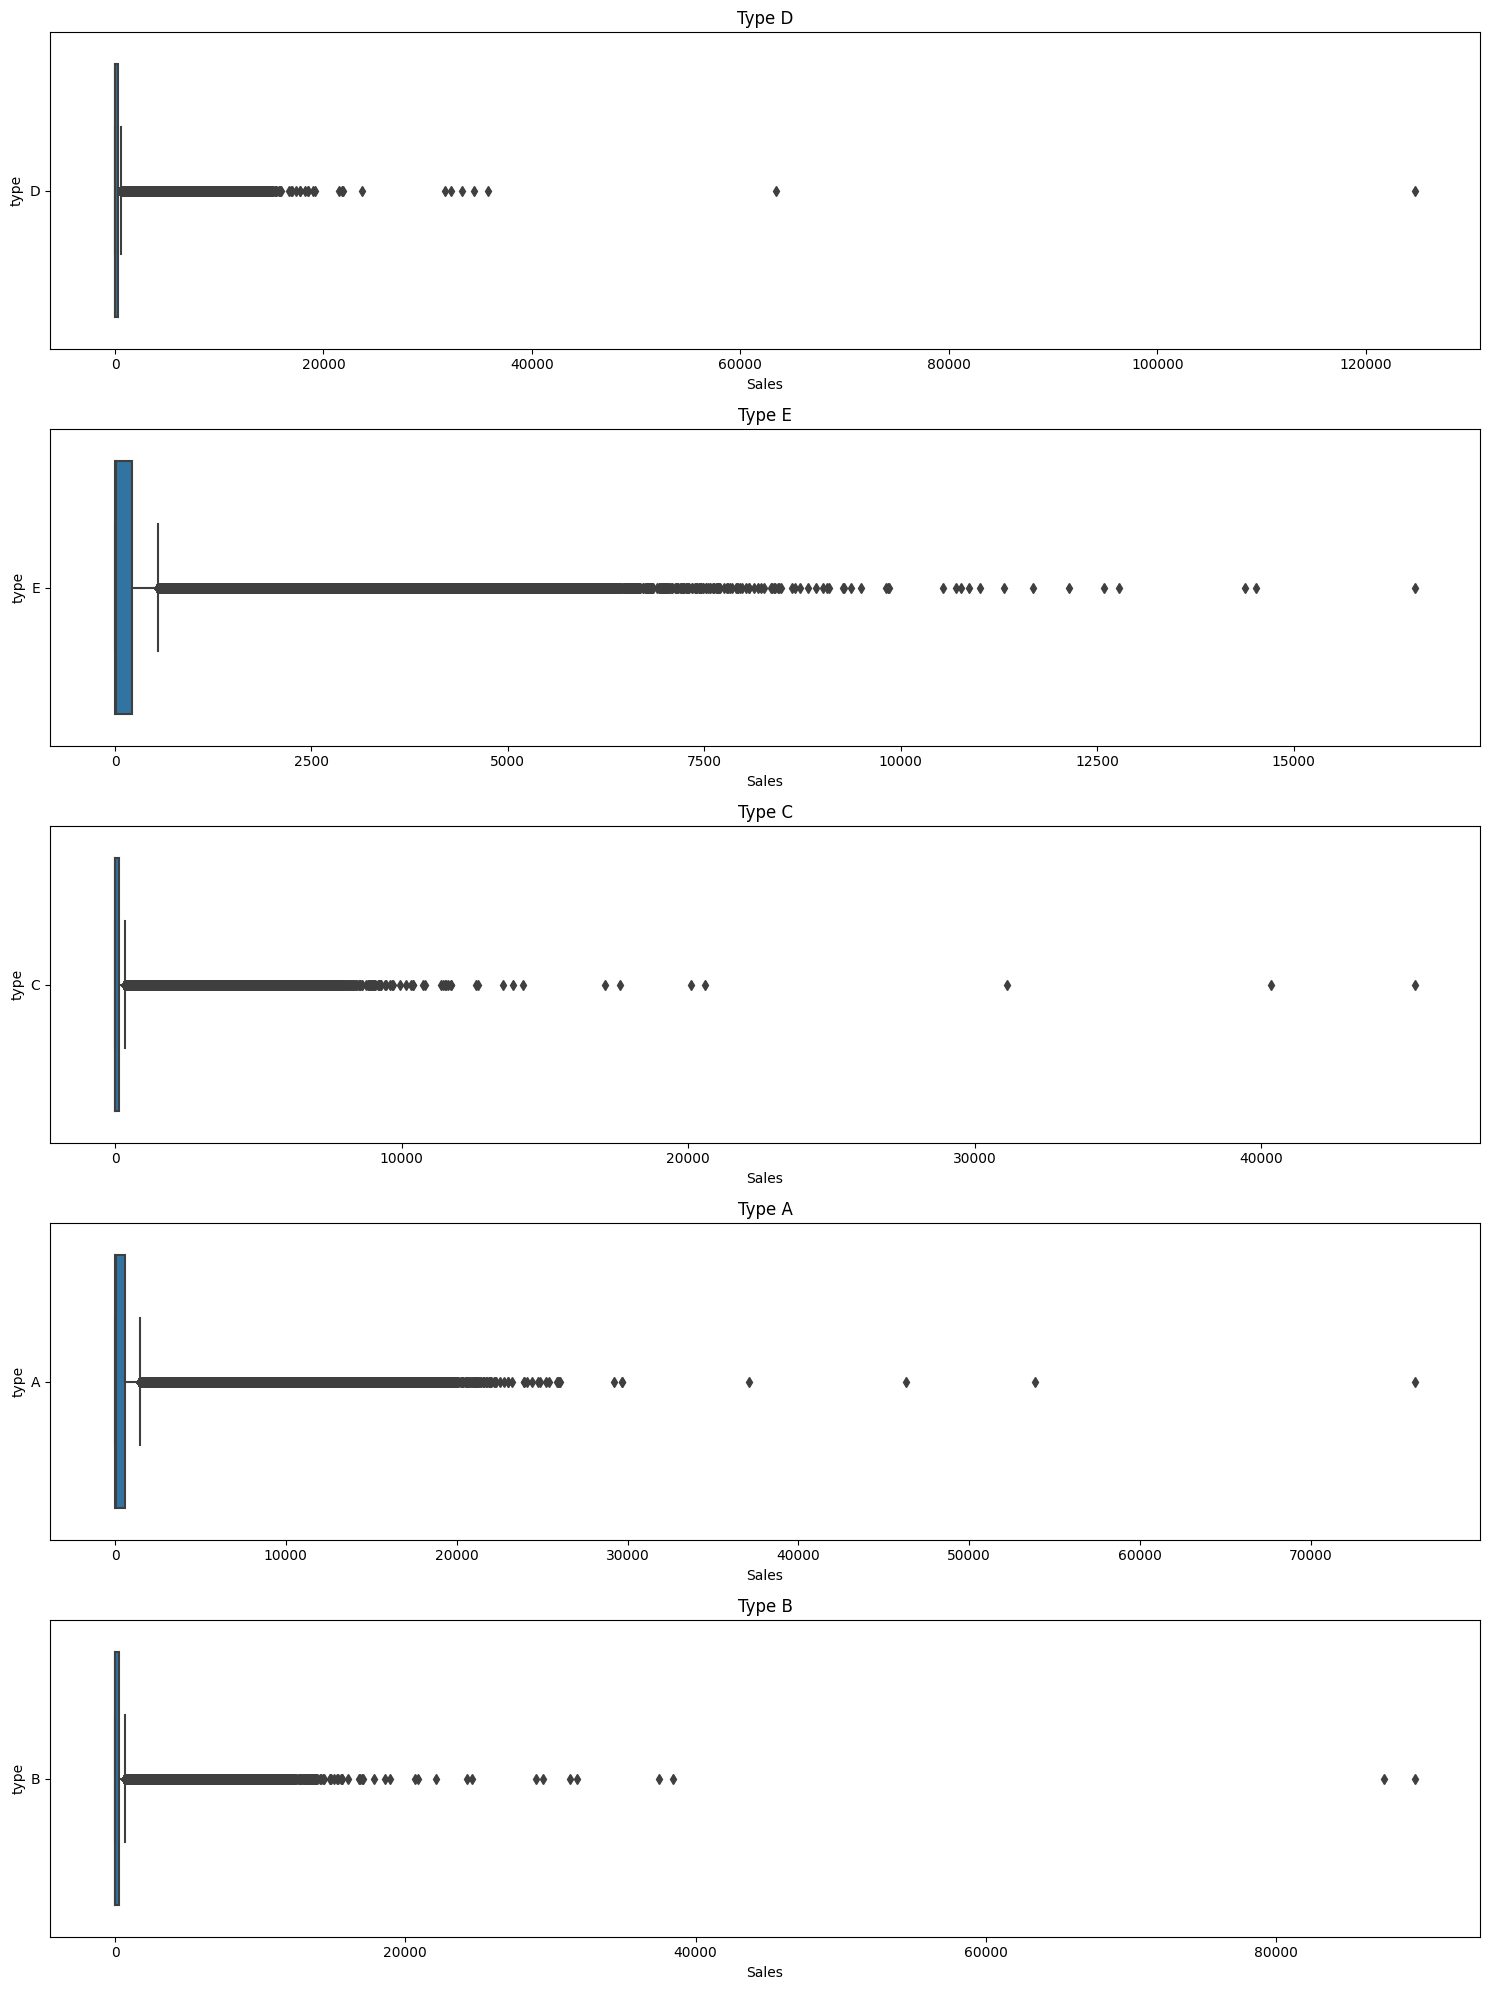

In [29]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20))

# 각 type에 대한 상자 수염 그림을 해당 서브플롯에 그림
types = train['type'].unique()
for i, ax in enumerate(axes.flatten()):
    if i < len(types):
        sns.boxplot(x='sales', y='type', data=train[train['type'] == types[i]], ax=ax)
        ax.set_title(f'Type {types[i]}')
        ax.set(xlabel='Sales')

# 서브플롯 간의 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

- 매장 type별로 매출액에 큰 차이가 있음을 확인할 수 있다.
  - `type`에 따라 각각 다른 모델을 구축하기로 함

In [30]:
### 데이터를 type 별로 분리

typeA = train.loc[train['type'] == 'A', :]
typeB = train.loc[train['type'] == 'B', :]
typeC = train.loc[train['type'] == 'C', :]
typeD = train.loc[train['type'] == 'D', :]
typeE = train.loc[train['type'] == 'E', :]

In [31]:
### 데이터를 type 별로 분리

typeA_te = test.loc[test['type'] == 'A', :]
typeB_te = test.loc[test['type'] == 'B', :]
typeC_te = test.loc[test['type'] == 'C', :]
typeD_te = test.loc[test['type'] == 'D', :]
typeE_te = test.loc[test['type'] == 'E', :]

# **4. EDA(2)**
- type별로 분리하여 모델링을 진행해 보자.

## **4-1. Type A**

In [32]:
typeA = typeA.drop('type', axis = 1) # 더 이상 type 변수는 필요 없으므로 삭제
typeA_te = typeA_te.drop('type', axis = 1) # 더 이상 type 변수는 필요 없으므로 삭제

In [33]:
typeA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435786 entries, 76 to 2704223
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            435786 non-null  int64         
 1   date          435786 non-null  datetime64[ns]
 2   store_nbr     435786 non-null  int64         
 3   family        435786 non-null  object        
 4   sales         435786 non-null  float64       
 5   onpromotion   435786 non-null  float64       
 6   city          435786 non-null  object        
 7   state         435786 non-null  object        
 8   cluster       435786 non-null  int64         
 9   dcoilwtico    435786 non-null  float64       
 10  transactions  435274 non-null  float64       
 11  holiday       435786 non-null  object        
 12  year          435786 non-null  int64         
 13  quarter       435786 non-null  int64         
 14  month         435786 non-null  int64         
 15  day_of_week   4

In [34]:
# 수치형 변수들의 기초통계량 확인

typeA[['sales', 'onpromotion', 'dcoilwtico', 'transactions']].describe()

,sales,onpromotion,dcoilwtico,transactions
count,435786.00,435786.00,435786.00,435274.00
mean,810.13,3.45,67.70,3176.44
std,2006.72,14.80,25.64,1061.31
min,0.00,0.00,26.19,0.00
25%,4.00,0.00,46.32,2404.00
50%,50.06,0.00,53.21,3130.00
75%,592.89,1.00,95.70,3866.00
max,76090.00,252.00,110.62,8359.00


- target 변수인 `sales`는 굉장히 왜곡된 분포를 보이고 있다.
  - `np.log1p()`를 통한 로그 변환 수행 후 모델링하면 좋을 듯하다.
- `onpromotion` 변수의 경우 심하게 왜곡된 분포를 가지고 있음
  - 상관관계를 보고 전처리 유무를 결정하자.


### **🧡 store_nbr**

In [35]:
# 고유한 매장 수

typeA['store_nbr'].unique()

array([45, 44, 46, 48, 49, 47, 51, 50, 52])

In [36]:
### 각 매장별 매출 총액 시도표(일 단위)

a = typeA.set_index("date").groupby("store_nbr").resample("D").sales.sum().reset_index()
px.line(a, x = "date", y= "sales", color = "store_nbr", title = "Daily total sales of the stores_Type A")

- 각 매장마다 매출이 상이한 것을 확인할 수 있다.
- 45번 매장의 경우 매출액이 다른 매장에 비해 큰 것을 확인할 수 있다.
- 52번 매장의 경우 비교적 최근에 개장한 점을 확인할 수 있다.
> 모델링 시 매장 번호를 one-hot encoding 후 반영하는 것이 좋을 것이라고 판단됨

### **💛 family**

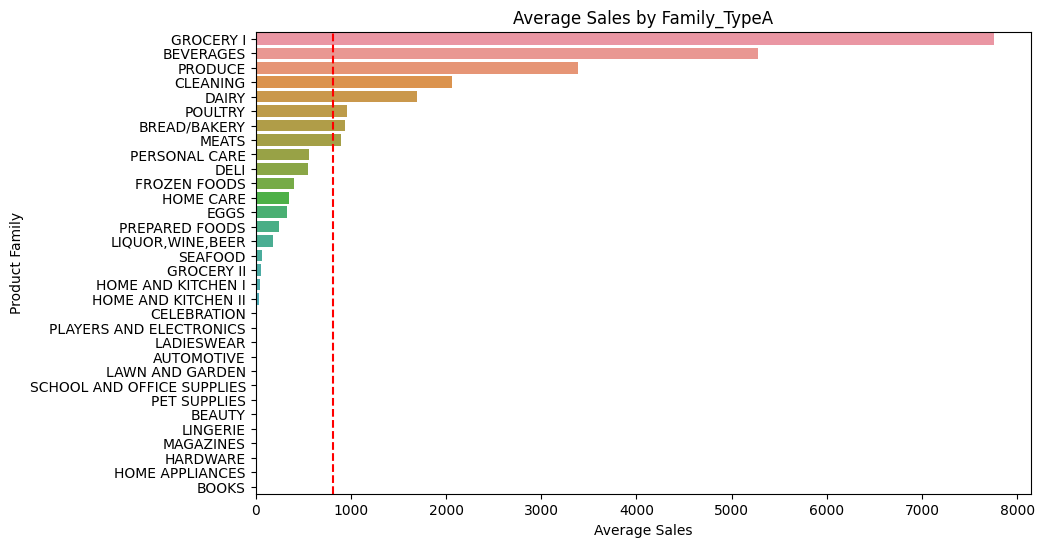

In [37]:
### 각 품목별로 매출에 미치는 영향

# 각 family 별로 'sales'의 평균을 계산하고, 내림차순으로 정렬
average_sales_by_family = typeA.groupby('family')['sales'].mean().sort_values(ascending=False)

## 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='sales', y='family', data=typeA, order=average_sales_by_family.index, ci=None)
plt.axvline(x=typeA['sales'].mean(), color='red', linestyle='--') # 매출 전체 평균

# 그래프 제목 및 레이블 설정
plt.title('Average Sales by Family_TypeA')
plt.xlabel('Average Sales')
plt.ylabel('Product Family')
plt.show()

- groceryI과 beverage가 매출의 대부분을 차지한다.
> 모델링 시 제품군을 one-hot encoding 후 반영하는 것이 좋을 것이라고 판단됨

### **💚 onpromotion**

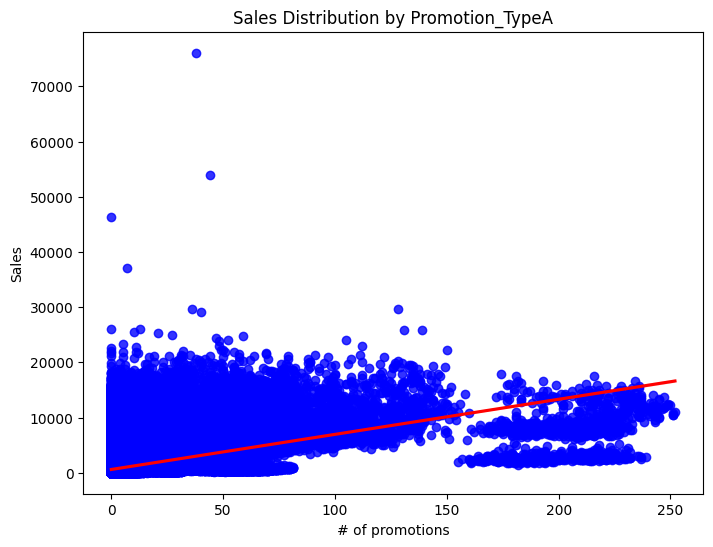

In [38]:
plt.figure(figsize=(8, 6))

sns.regplot(x='onpromotion', y='sales', data=typeA, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Promotion_TypeA')
plt.xlabel('# of promotions')
plt.ylabel('Sales')
plt.show()

- 약한 양의 상관관계를 보인다.
- promotion되는 제품 수와 상관 없이 매출액이 큰 경우들이 존재함을 확인할 수 있다.

### **💙 state**

In [39]:
# 고유한 주(state) 수

typeA['state'].unique()

array(['Pichincha', 'Guayas', 'Tungurahua', 'Manabi'], dtype=object)

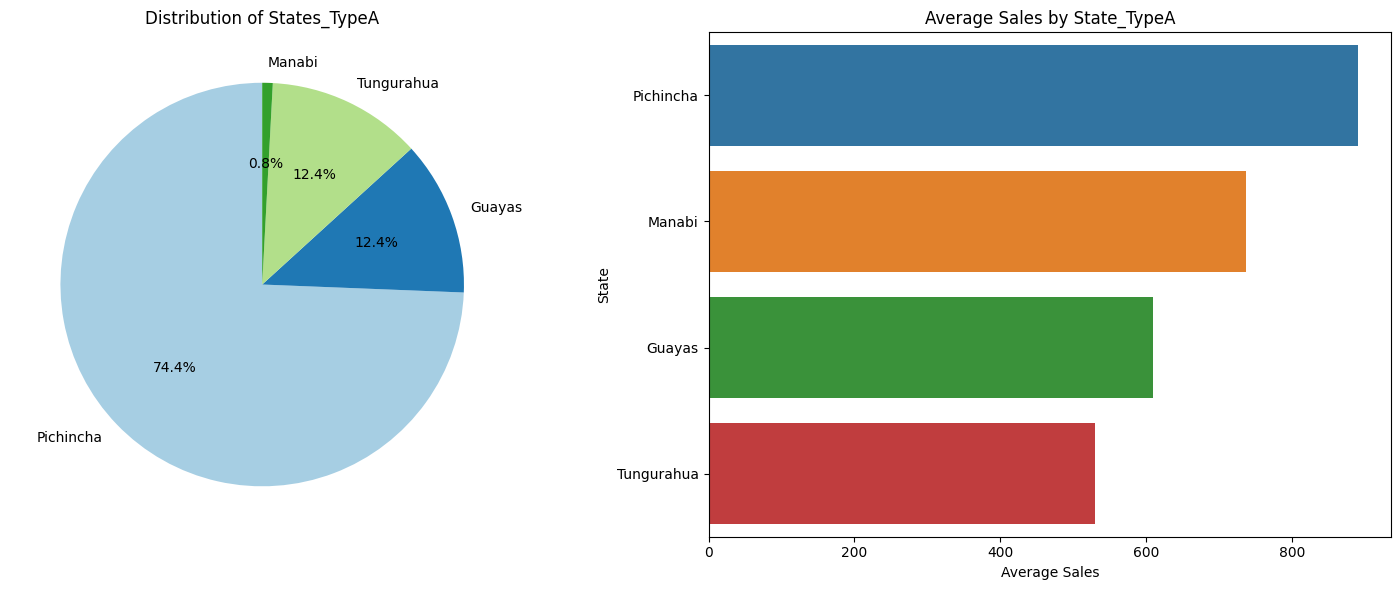

In [40]:
plt.figure(figsize=(15, 6))

# 첫 번째 subplot: 파이 차트
plt.subplot(1, 2, 1)
state_counts = typeA['state'].value_counts()
plt.pie(state_counts, labels=state_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of States_TypeA')

# 두 번째 subplot: 막대 그래프
plt.subplot(1, 2, 2)
average_sales_by_state = typeA.groupby('state')['sales'].mean().sort_values(ascending=False)
sns.barplot(x='sales', y='state', data=typeA, order=average_sales_by_state.index, ci=None)

plt.title('Average Sales by State_TypeA')
plt.xlabel('Average Sales')
plt.ylabel('State')
plt.tight_layout()
plt.show()

- 주마다 매출액에 차이가 있음을 확인할 수 있다.
- Manabi 주의 경우 굉장히 적은 데이터 건수임에도 불구하고 매출에 큰 영향을 미침을 확인할 수 있다.

### **💜 city**

In [41]:
# 고유한 도시(city) 수

print(typeA.groupby('state')['store_nbr'].unique())
print()
print(typeA.groupby('state')['city'].unique())

state
Guayas                            [51]
Manabi                            [52]
Pichincha     [45, 44, 46, 48, 49, 47]
Tungurahua                        [50]
Name: store_nbr, dtype: object

state
Guayas        [Guayaquil]
Manabi            [Manta]
Pichincha         [Quito]
Tungurahua       [Ambato]
Name: city, dtype: object


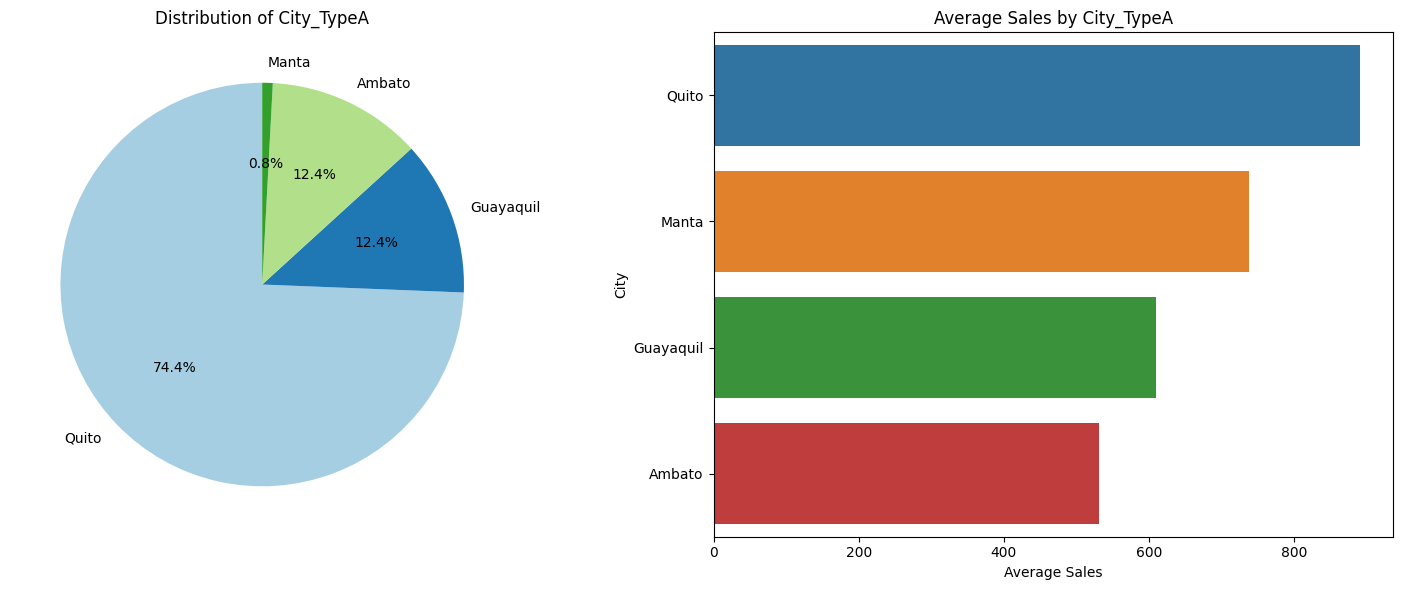

In [42]:
plt.figure(figsize=(15, 6))

# 첫 번째 subplot: 파이 차트
plt.subplot(1, 2, 1)
city_counts = typeA['city'].value_counts()
plt.pie(city_counts, labels=city_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of City_TypeA')

# 두 번째 subplot: 막대 그래프
plt.subplot(1, 2, 2)
average_sales_by_city = typeA.groupby('city')['sales'].mean().sort_values(ascending=False)
sns.barplot(x='sales', y='city', data=typeA, order=average_sales_by_city.index, ci=None)

plt.title('Average Sales by City_TypeA')
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.tight_layout()
plt.show()

- `state`를 통해 `city`가 다 구분되는 상황
  - `sales`의 양상이 `state`와 유사
  - `state` 변수 하나만 남기기로 결정

### **🤎dcoilwtico**

In [43]:
import plotly.express as px

daily_oil_price = typeA.groupby("date")["dcoilwtico"].mean().reset_index()

# 그래프 그리기
fig = px.line(daily_oil_price, x="date", y="dcoilwtico", title="Daily DcoilWTICO Prices")
fig.show()

- 유가 변동 경향과 sales의 변동이 별 상관은 없어 보인다.(추세가 다름)
- 2014년을 기점으로 급격하게 감소하는 추세를 보인다.
  - 그에 비해 매출은 그렇게 오르지 않았다.

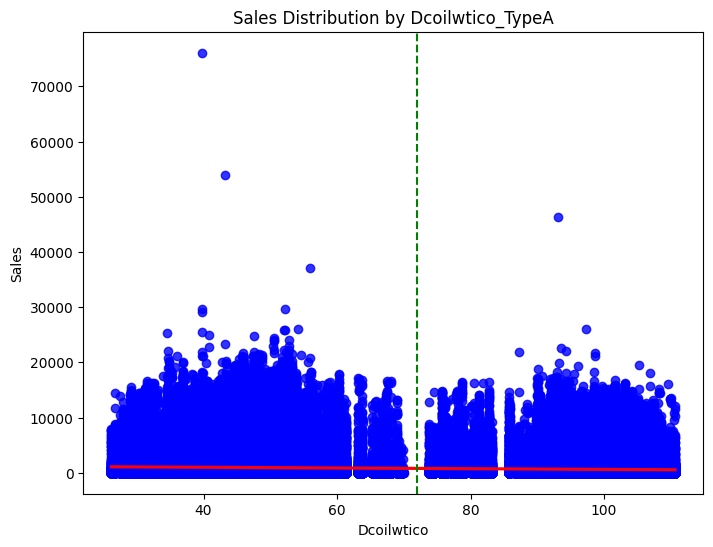

In [44]:
plt.figure(figsize=(8, 6))

sns.regplot(x='dcoilwtico', y='sales', data=typeA, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.axvline(x=72, color='green', linestyle='--') # 72 구분선

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Dcoilwtico_TypeA')
plt.xlabel('Dcoilwtico')
plt.ylabel('Sales')
plt.show()

- 정말 별 상관은 없어 보인다.
- 다만 유가가 **72** 전후에서 두 개의 그룹으로 확연히 분리되는 것을 확인할 수 있다.

In [45]:
under72 = typeA.loc[typeA['dcoilwtico'] <= 72,:]
over72 = typeA.loc[typeA['dcoilwtico'] > 72,:]

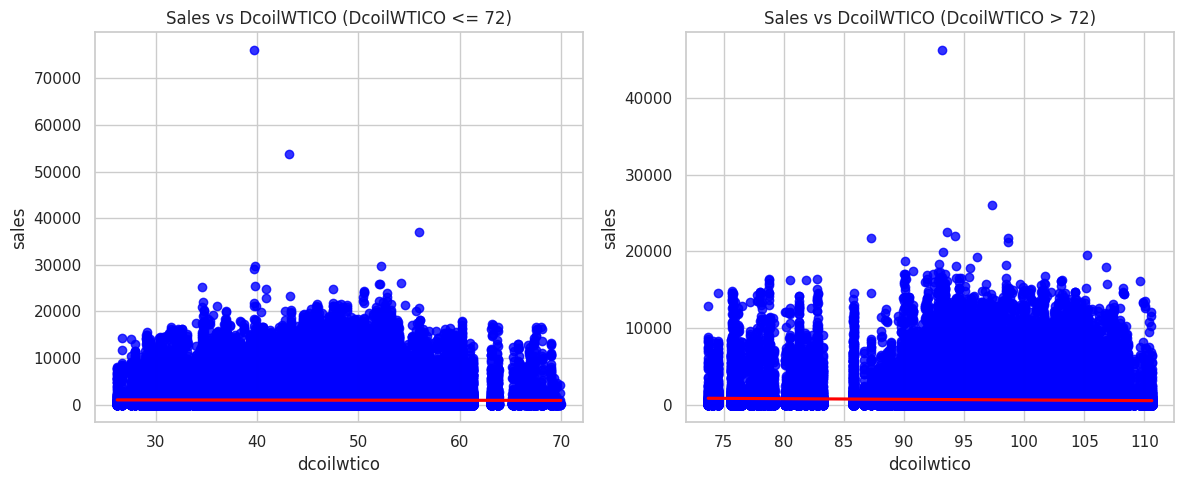

In [46]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot regplot for 'dcoilwtico' <= 72
sns.regplot(x='dcoilwtico', y='sales', data=under72, ax=axes[0], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
axes[0].set_title('Sales vs DcoilWTICO (DcoilWTICO <= 72)')

# Plot regplot for 'dcoilwtico' > 72
sns.regplot(x='dcoilwtico', y='sales', data=over72, ax=axes[1], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
axes[1].set_title('Sales vs DcoilWTICO (DcoilWTICO > 72)')

# Adjust layout
plt.tight_layout()
plt.show()

- 차이가 나타나진 않는다..

### **💗 transactions**

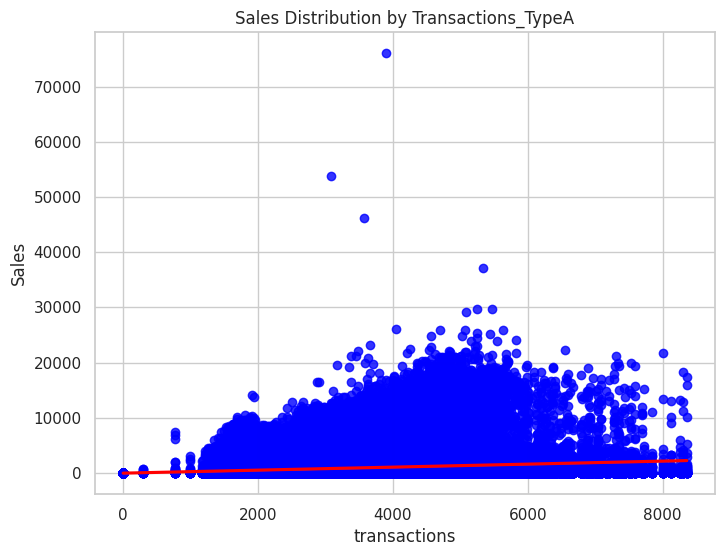

In [47]:
plt.figure(figsize=(8, 6))

sns.regplot(x='transactions', y='sales', data=typeA, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

# 그래프 제목 및 레이블 설정
plt.title('Sales Distribution by Transactions_TypeA')
plt.xlabel('transactions')
plt.ylabel('Sales')
plt.show()

- 약한 양의 상관관계를 보인다.
- 그닥 상관은 없어 보인다.  
(어짜피 모델링 시 활용하기 어려움..)

### **🤍 holiday**

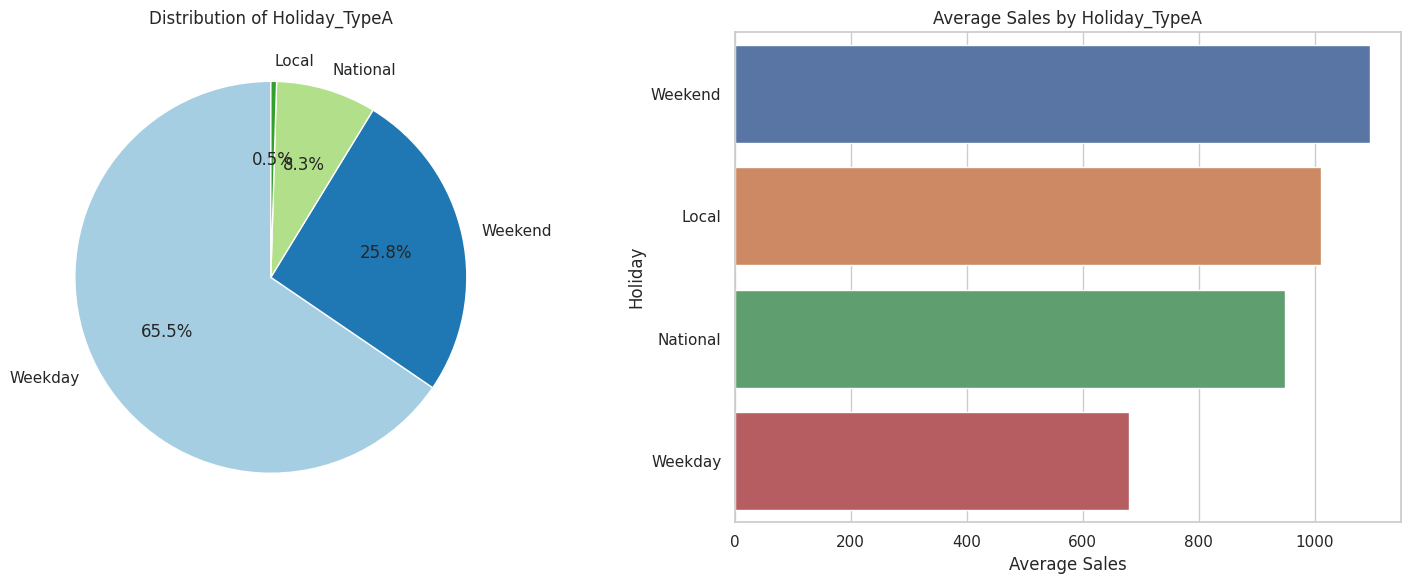

In [48]:
plt.figure(figsize=(15, 6))

# 첫 번째 subplot: 파이 차트
plt.subplot(1, 2, 1)
holiday_counts = typeA['holiday'].value_counts()
plt.pie(holiday_counts, labels=holiday_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of Holiday_TypeA')

# 두 번째 subplot: 막대 그래프
plt.subplot(1, 2, 2)
average_sales_by_holiday = typeA.groupby('holiday')['sales'].mean().sort_values(ascending=False)
sns.barplot(x='sales', y='holiday', data=typeA, order=average_sales_by_holiday.index, ci=None)

plt.title('Average Sales by Holiday_TypeA')
plt.xlabel('Average Sales')
plt.ylabel('Holiday')
plt.tight_layout()
plt.show()

- 그냥 주말(공휴일은 제외됨)에 매출이 가장 좋다.

### **⭐Target 변수(Sales)**
- 여러 요인에 따라 매출이 어떻게 달라지는지 살펴보자.

#### **a) 시간 관련 변수**

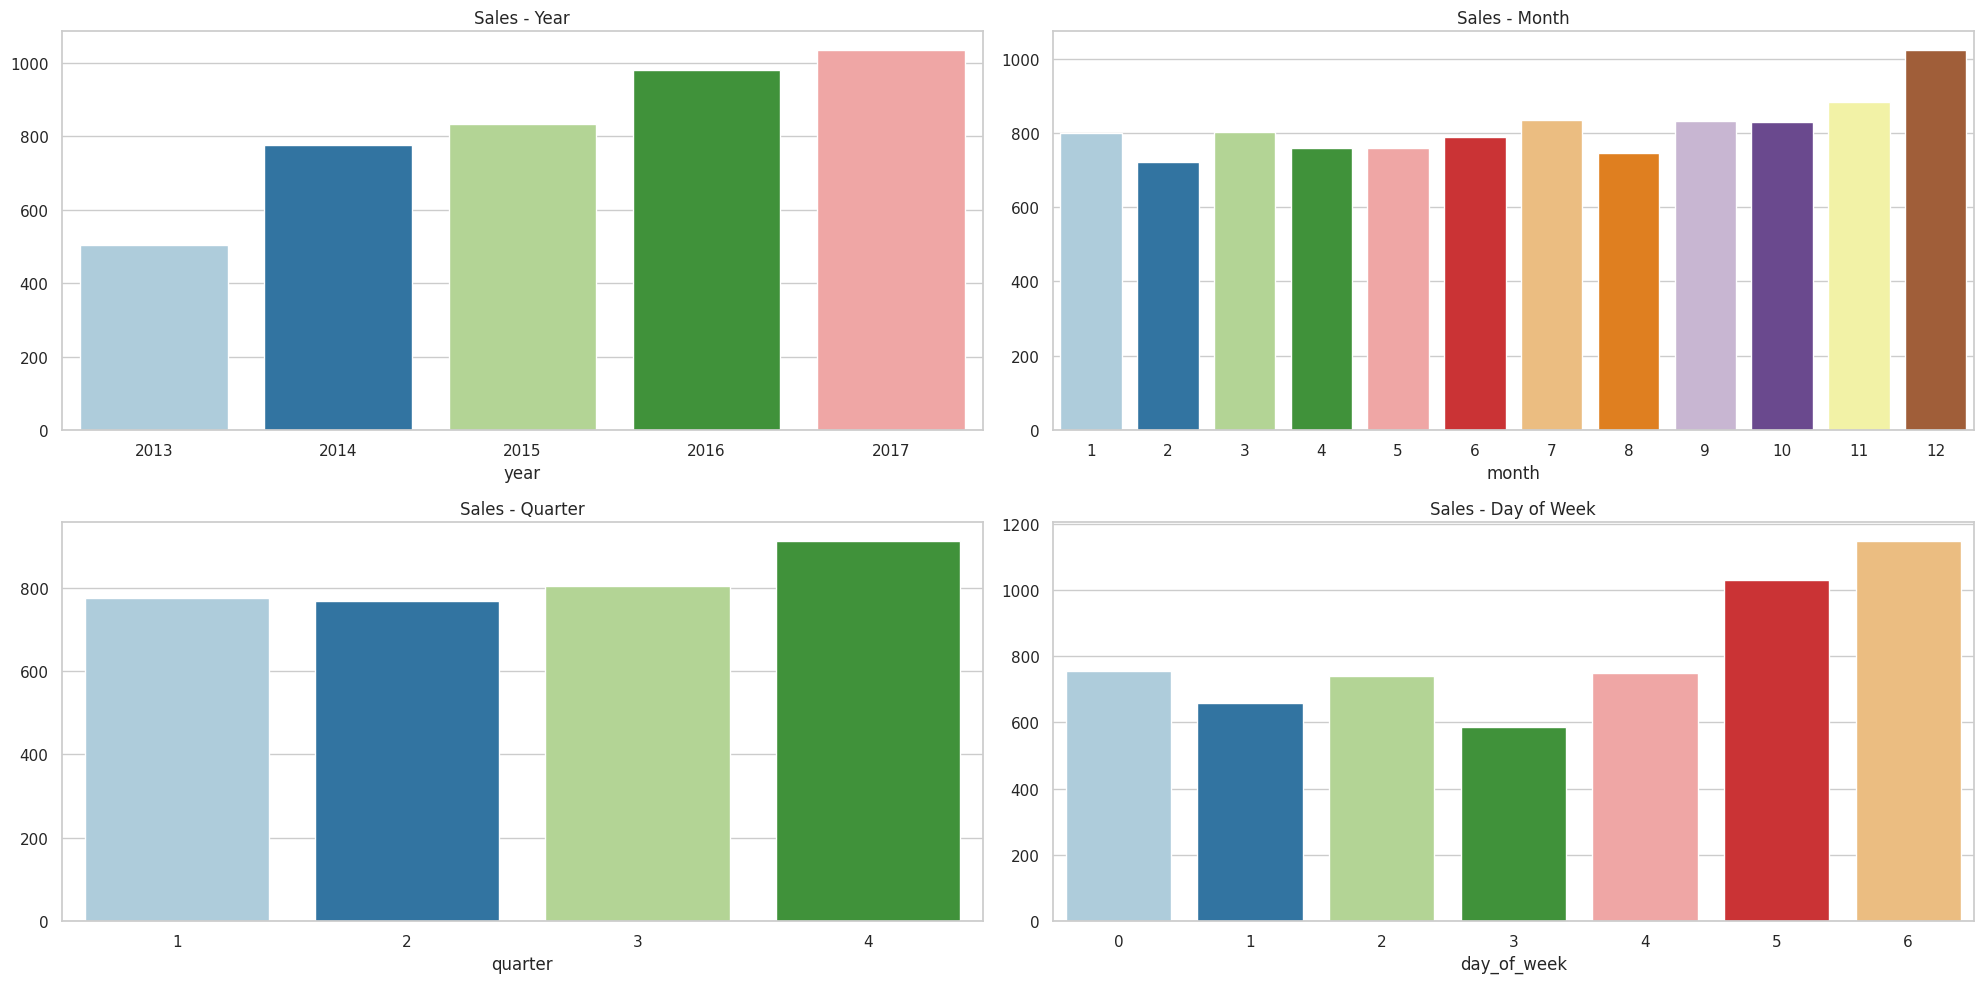

In [49]:
### 평균 매출액으로 시각화
data_grouped_year = typeA.groupby(['year']).mean()['sales']
data_grouped_month = typeA.groupby(['month']).mean()['sales']
data_grouped_quarter = typeA.groupby(['quarter']).mean()['sales']
data_grouped_day = typeA.groupby(['day_of_week']).mean()['sales']

palette = sns.color_palette("Paired")

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
# 연도별 매출
axes[0, 0].set_title('Sales - Year')
sns.barplot(x=data_grouped_year.index, y=data_grouped_year.values, ax=axes[0, 0], palette=palette)
# 월별 매출
axes[0, 1].set_title('Sales - Month')
sns.barplot(x=data_grouped_month.index, y=data_grouped_month.values, ax=axes[0, 1], palette=palette)
# 분기별 매출
axes[1, 0].set_title('Sales - Quarter')
sns.barplot(x=data_grouped_quarter.index, y=data_grouped_quarter.values, ax=axes[1, 0], palette=palette)
# 요일별 매출
axes[1, 1].set_title('Sales - Day of Week')
sns.barplot(x=data_grouped_day.index, y=data_grouped_day.values, ax=axes[1, 1], palette=palette)

plt.tight_layout()
plt.show()

**연도별 매출**
- 뒤로 갈수록 매출액이 점점 증가하고 있다.

**월별 & 분기별 매출**  
- 대체로 비슷한 경향을 보이나, 12월에 매출이 증가
- 4분기에 매출 증가

**요일별 매출**  
- 평일에 비해 주말의 매출액이 더 높다.

#### **b) 변수들 간의 상관관계**
- 상관계수는 수치형 변수들끼리만 비교 가능

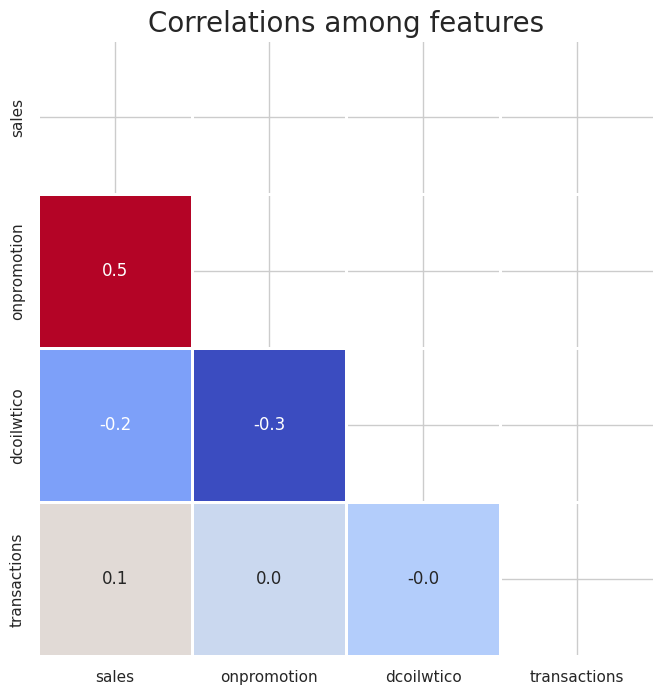

In [50]:
num_ftrs = typeA[['sales', 'onpromotion','dcoilwtico','transactions']]

mask = np.triu(num_ftrs.corr(method = 'spearman'))

# heatmap을 이용한 시각화
plt.figure(figsize=(8, 8))
sns.heatmap(num_ftrs.corr(method = 'spearman'),
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)
plt.title("Correlations among features", fontsize=20)
plt.show()

### **💡 후처리**

#### **최종 변수 선택**

In [51]:
typeA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435786 entries, 76 to 2704223
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            435786 non-null  int64         
 1   date          435786 non-null  datetime64[ns]
 2   store_nbr     435786 non-null  int64         
 3   family        435786 non-null  object        
 4   sales         435786 non-null  float64       
 5   onpromotion   435786 non-null  float64       
 6   city          435786 non-null  object        
 7   state         435786 non-null  object        
 8   cluster       435786 non-null  int64         
 9   dcoilwtico    435786 non-null  float64       
 10  transactions  435274 non-null  float64       
 11  holiday       435786 non-null  object        
 12  year          435786 non-null  int64         
 13  quarter       435786 non-null  int64         
 14  month         435786 non-null  int64         
 15  day_of_week   4

In [52]:
typeA = typeA[['store_nbr', 'family', 'sales', 'onpromotion', 'state', 'cluster', 'dcoilwtico', 'holiday', 'year', 'quarter', 'month', 'day_of_week']]

# test의 경우에는 이후 submission 파일 작성을 위해 일단 id를 남겨두기로 결정
typeA_te = typeA_te[['id', 'store_nbr', 'family', 'onpromotion', 'state', 'cluster', 'dcoilwtico', 'holiday', 'year', 'quarter', 'month', 'day_of_week']]

In [53]:
typeA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435786 entries, 76 to 2704223
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   store_nbr    435786 non-null  int64  
 1   family       435786 non-null  object 
 2   sales        435786 non-null  float64
 3   onpromotion  435786 non-null  float64
 4   state        435786 non-null  object 
 5   cluster      435786 non-null  int64  
 6   dcoilwtico   435786 non-null  float64
 7   holiday      435786 non-null  object 
 8   year         435786 non-null  int64  
 9   quarter      435786 non-null  int64  
 10  month        435786 non-null  int64  
 11  day_of_week  435786 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 43.2+ MB


#### **변수 왜곡 정도 확인**

In [54]:
# 수치형 변수들에 대해서만 왜도 확인

num_ftrs = typeA[['sales', 'onpromotion','dcoilwtico']]
num_ftrs.skew()

sales         4.36
onpromotion   8.83
dcoilwtico    0.32
dtype: float64

In [55]:
typeA['sales'] = np.log1p(typeA['sales'])
typeA['onpromotion'] = np.log1p(typeA['onpromotion'])

In [56]:
typeA_te['onpromotion'] = np.log1p(typeA_te['onpromotion'])

In [57]:
typeA[['sales', 'onpromotion','dcoilwtico']].skew()

sales         0.03
onpromotion   2.34
dcoilwtico    0.32
dtype: float64

- 왜곡 정도가 많이 개선되었다.

#### **스케일링**
- 수치형 변수들에 대한 스케일링 진행

In [58]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected variables
typeA[['onpromotion', 'dcoilwtico']] = scaler.fit_transform(typeA[['onpromotion', 'dcoilwtico']])
typeA_te[['onpromotion', 'dcoilwtico']] = scaler.transform(typeA_te[['onpromotion', 'dcoilwtico']])

In [59]:
typeA.head()

,store_nbr,family,sales,onpromotion,state,cluster,dcoilwtico,holiday,year,quarter,month,day_of_week
76,45,LADIESWEAR,0.00,-0.49,Pichincha,11,0.99,National,2013,1,1,1
77,45,HOME CARE,0.00,-0.49,Pichincha,11,0.99,National,2013,1,1,1
78,45,HOME APPLIANCES,0.00,-0.49,Pichincha,11,0.99,National,2013,1,1,1
79,45,HOME AND KITCHEN II,0.00,-0.49,Pichincha,11,0.99,National,2013,1,1,1
80,45,HOME AND KITCHEN I,0.00,-0.49,Pichincha,11,0.99,National,2013,1,1,1


In [60]:
typeA_te.head()

,id,store_nbr,family,onpromotion,state,cluster,dcoilwtico,holiday,year,quarter,month,day_of_week
1254,3002142,44,AUTOMOTIVE,-0.49,Pichincha,5,-0.82,Weekday,2017,3,8,2
1255,3002143,44,BABY CARE,-0.49,Pichincha,5,-0.82,Weekday,2017,3,8,2
1256,3002144,44,BEAUTY,0.62,Pichincha,5,-0.82,Weekday,2017,3,8,2
1257,3002145,44,BEVERAGES,2.71,Pichincha,5,-0.82,Weekday,2017,3,8,2
1258,3002146,44,BOOKS,-0.49,Pichincha,5,-0.82,Weekday,2017,3,8,2


#### **범주형 변수 처리**

In [61]:
typeA = pd.get_dummies(typeA, columns=['store_nbr','family', 'state', 'cluster', 'holiday', 'year', 'quarter', 'month', 'day_of_week'])
typeA.head()

,sales,onpromotion,dcoilwtico,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,family_AUTOMOTIVE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,state_Guayas,state_Manabi,state_Pichincha,state_Tungurahua,cluster_5,cluster_11,cluster_14,cluster_17,holiday_Local,holiday_National,holiday_Weekday,holiday_Weekend,year_2013,year_2014,year_2015,year_2016,year_2017,quarter_1,quarter_2,quarter_3,quarter_4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
76,0.00,-0.49,0.99,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
77,0.00,-0.49,0.99,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
78,0.00,-0.49,0.99,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
79,0.00,-0.49,0.99,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
80,0.00,-0.49,0.99,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [62]:
typeA_te = pd.get_dummies(typeA_te, columns=['store_nbr','family', 'state', 'cluster', 'holiday', 'year', 'quarter', 'month', 'day_of_week'])
typeA_te.head()

,id,onpromotion,dcoilwtico,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,state_Guayas,state_Manabi,state_Pichincha,state_Tungurahua,cluster_5,cluster_11,cluster_14,cluster_17,holiday_Local,holiday_Weekday,holiday_Weekend,year_2017,quarter_3,month_8,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
1254,3002142,-0.49,-0.82,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0
1255,3002143,-0.49,-0.82,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0
1256,3002144,0.62,-0.82,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0
1257,3002145,2.71,-0.82,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0
1258,3002146,-0.49,-0.82,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0


In [63]:
typeA.shape

(435786, 84)

- 83개의 feature 변수, 1개의 target 변수

In [64]:
typeA_te.shape

(4752, 66)

- 차이가 나는 부분
  - holiday
  - year
  - quarter
  - month

In [66]:
## 변수 추가

typeA_te[['holiday_National', 'year_2013', 'year_2014', 'year_2015', 'year_2016', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_9', 'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2', 'quarter_4']] = 0

In [67]:
typeA_te.shape

(4752, 85)

In [74]:
typeA.columns.difference(typeA_te.columns)

Index(['sales'], dtype='object')

In [75]:
typeA_te.columns.difference(typeA.columns)

Index(['family_BABY CARE', 'id'], dtype='object')

- typeA에 속하는 매장들은 해당 제품군을 판매하지 x
  - 모델링 시에는 삭제
- 이후 예측값을 다 0으로 표시


In [78]:
# 최종 파일 저장

typeA.to_csv('/content/drive/MyDrive/Colab Notebooks/ESAA 8기/OB/winter_proj/data/modeling/train/typeA.csv', index = False)
typeA_te.to_csv('/content/drive/MyDrive/Colab Notebooks/ESAA 8기/OB/winter_proj/data/modeling/test/typeA_te.csv', index = False)